## PM2.5 Regression
The objective of this study is to calibrate a portable PM2.5 measurement device.

Main topics includes:
- Calibration of Portable PM2.5 Measuring Device


Last edited on 5/31/2018

Doc structure levels 1(#) and 2(##) are just for reference only.


In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# set precision of floating point number
%precision 2

# plot settings
plotFontSize = 12

# Disable core warning message from Tensorflow
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# for consistent results
#np.random.seed(10)
#from tensorflow import set_random_seed
#set_random_seed(20) # set random

from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr

# Update figures
savefig = True

### Preprocessing of Data

In [67]:
import statsmodels.api

In [68]:
datafile_csv = './csv/ShowPaperData-correlationData_Sungbukgu.csv'
data = pd.read_csv(datafile_csv) # raw pandas dataframe
data.head()

,hour,date,temperature,humidity,Sharp measured voltage[mv],measurement of certified station,Sharp PM2.5,error
0,1,2016-10-18:15,24.4,59.8,79.5,25,29.1,16.4%
1,2,2016-10-18:16,24.7,58.5,78.3,32,28.6,10.5%
2,3,2016-10-18:17,23.8,62.0,78.2,28,28.6,2.2%
3,4,2016-10-18:18,21.9,68.0,77.6,25,28.4,13.5%
4,5,2016-10-18:19,19.8,76.9,74.3,27,27.2,0.6%


#### Explanation of data keys

**data keys** : {{for i in data.keys().values:print('%s ,'%i)}}

The units of temperature and humidity are in degree Celcius and %.

Explanation of data headers

- Sharp measured voltage[mv] : Voltage measured by Portable PM2.5 Measuring Device.
- measurement of certificed station : PM2.5 measurement from government station(Sungbuk station) in $\mu g / m^3$
- Sharp PM2.5 : conversion of `Sharp measured voltage[mv]` to $\mu g /m^3$ using **linear regression**.
- error : deviataion of Sharp PM2.5 from measurement of certified station in %

**Rename data keys**
Sharp measured voltage[mv] : mpd (measurement of portable device)
measurement of certified station : mcs (measurement of certified station)

In [69]:
data.rename(columns={'Sharp measured voltage[mv]':'mpd'}, inplace=True)
data.rename(columns={'measurement of certified station':'mcs'}, inplace=True)
data.keys()

Index(['hour', 'date', 'temperature', 'humidity', 'mpd', 'mcs', 'Sharp PM2.5',
       'error'],
      dtype='object')

#### data analysis
histogram of measurements of government certified station at Sungbuk-Gu. Distribution of data indicates that number of data at relatively higher concentration is small.

/home/brian/keras_tf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


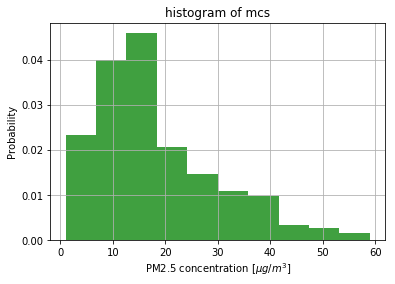

In [70]:
# the histogram of the data
histogramData = data['mcs']
n, bins, patches = plt.hist(histogramData, 10, normed=1, facecolor='green', alpha=0.75)
kk=[1,2,3]
plt.xlabel('PM2.5 concentration [$\mu g /m^3$]')
plt.ylabel('Probability')
plt.title('histogram of ' + '%s'%(histogramData.name))
#plt.axis([0, 160, 0, 0.03])
plt.grid(True)
plt.show()

#### Data Descriptive Statistics

In [71]:
data.describe()

,hour,temperature,humidity,mpd,mcs,Sharp PM2.5
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,165.012539,16.517555,71.013793,49.938558,18.163009,18.167085
std,96.149876,3.868475,17.849581,26.000844,11.629707,9.607335
min,1.000000,6.600000,18.700000,1.500000,1.000000,0.300000
25%,80.500000,13.900000,59.950000,30.450000,10.000000,10.950000
50%,166.000000,17.000000,72.700000,45.400000,15.000000,16.500000
75%,247.500000,19.050000,84.400000,61.850000,24.000000,22.550000
max,331.000000,24.700000,99.900000,122.600000,59.000000,45.000000


#### Sort data 

In [72]:
# sort data
#data.sort_values(by=['Sharp measured voltage[mv]'],ascending=True, inplace=True)
#data.head(5)

#### Preparing input and output
Input1 (X) : [temparature, humidity, Sharp-measured-voltage]<br>
Input2 (Xc) : Sharp-measured-voltage<br>
Output(y) : measurement of certified station (Sungbuk station)<br>
We will consider two cases for inputs; For the case 1, the input1 includes temperature, humidity, and Sharp-measured-voltage and for the case 2, the input2, only the Sharp-measured-voltage is considered.

In [73]:
X  = data.loc[:,{'temperature','humidity','mpd'}]
Xc = data['mpd'] # measurement of portable device
y  = data['mcs'] # measurement of certified station

In [74]:
#reshape single feature by first converting Pandas DataFrame into Numpy array
Xc = Xc.values.reshape(-1,1)

  Seaborn Pairwise plot
  
  <span style="color:red" >[FIGURE FOR PAPER]</span>
  

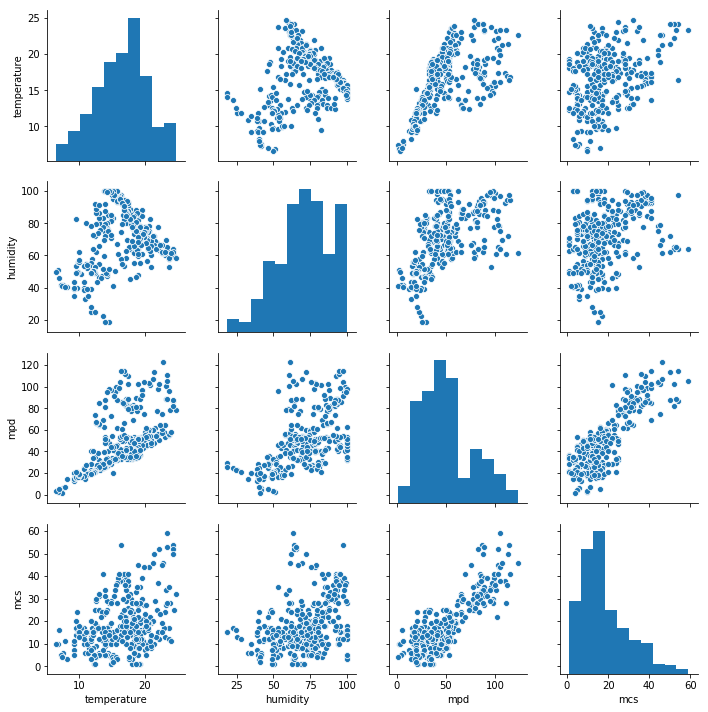

In [75]:
import seaborn as sns
pairplotData = data[['temperature','humidity','mpd','mcs']]
#sns.pairplot(pairplotData,hue='hospital stay class')
g = sns.pairplot(pairplotData)

if savefig:
    plt.savefig('./fig_Regression/pm25_pairplot.png', dpi=600,bbox_inches='tight')
#sns.plt.show()
plt.show()

#### Split data into train and test

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Single input and single output

In [77]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, y, test_size=0.2)

In [78]:
!pwd

/home/brian/keras_tf/PM2-5/Jupyter_notebook


#### Standardization of data [ just for reference ]
<span style='color:blue'> Just for reference, standardized data is not being used. </span>

In [79]:
from sklearn.preprocessing import StandardScaler
scalerS = StandardScaler().fit(X_train)
X_train_std_scaled = pd.DataFrame(scalerS.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_std_scaled = pd.DataFrame(scalerS.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)

 plot of standardized data

/home/brian/keras_tf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


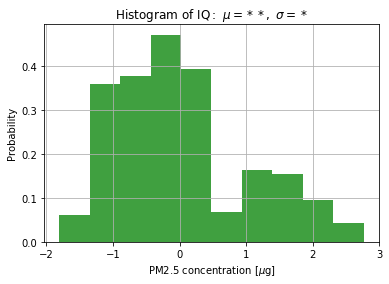

In [80]:
# the histogram of the data
histogramData = X_train_std_scaled['mpd']
n, bins, patches = plt.hist(histogramData, 10, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('PM2.5 concentration [$\mu$g]')
plt.ylabel('Probability')
plt.title('$\mathrm{Histogram\ of\ IQ:}\ \mu=**,\ \sigma=*$')
#plt.axis([0, 160, 0, 0.03])
plt.grid(True)
plt.show()

#### MinMax Scaled Data

In [81]:
from sklearn.preprocessing import MinMaxScaler
# Input(Features) scaling
scalerMx = MinMaxScaler().fit(X)
X_train_mm_scaled = pd.DataFrame(scalerMx.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_mm_scaled = pd.DataFrame(scalerMx.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)


# Output(Label) scaling
scalerMy = MinMaxScaler().fit(y.values.reshape(-1,1))
y_train_mm_scaled = pd.DataFrame(scalerMy.transform(y_train.values.reshape(-1,1)))
y_test_mm_scaled = pd.DataFrame(scalerMy.transform(y_test.values.reshape(-1,1)))

/home/brian/keras_tf/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [82]:
scalerMx.transform(X_train);

### Regression Analysis : statsmodels regression

In [83]:
import statsmodels.api as sm

                            OLS Regression Results                            
Dep. Variable:                    mcs   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     273.8
Date:                Wed, 05 Dec 2018   Prob (F-statistic):           7.73e-79
Time:                        15:37:18   Log-Likelihood:                -804.11
No. Observations:                 255   AIC:                             1616.
Df Residuals:                     251   BIC:                             1630.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          19.7296      2.090      9.439      

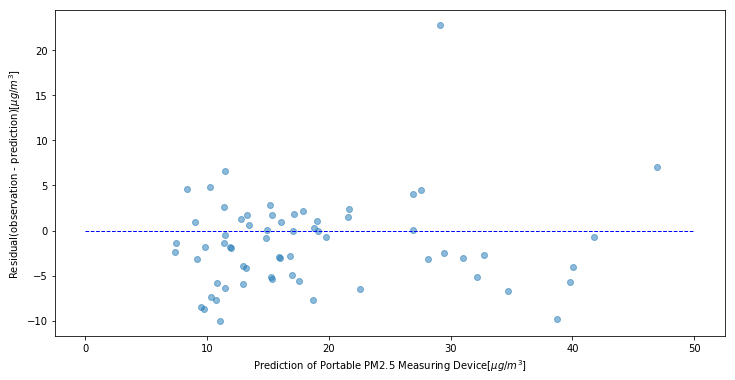

In [84]:
## import statsmodels.api as sm
import statsmodels.api as sm
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

xst_train = sm.add_constant(X_train) # including intercept
xst_test = sm.add_constant(X_test)

yst_train,yst_test = y_train, y_test
# model
stats_model = sm.OLS(yst_train, xst_train)
# fit
stats_model_results = stats_model.fit()
# predict
yst_prediction = stats_model_results.predict(xst_test)
# print summary
print(stats_model_results.summary())

# calculate variance_inflation_factor
vif = pd.DataFrame()
vif['vif factor'] = [variance_inflation_factor(xst_train.values,i) \
                        for i in range(xst_train.shape[1]) ]
vif['features'] = xst_train.columns
print('********* variable inflaion factor ******************')
print(vif.round(2))
print('*****************************************************')



# calculate RMS error
f_error_squared = lambda x,y: (x-y)*(x-y)
squared_error_st = f_error_squared(y_test,yst_prediction)
# mean
mse_st = squared_error_st.mean()
# standard deviation
std_st = squared_error_st.std()
# root mean squared error
rmse_st = np.sqrt(mse_st)
# root standard deviation of squared error
rstd_st = np.sqrt(std_st)

std_squared_error_st=f_error_squared(y_test,yst_prediction).std()

print('mean of observation: %.2f' %(np.mean(y_test)))
print('root mean squared error:%.2f, root-standard-deviation of squared error:%.2f' %(rmse_st,rstd_st))

# R2
print('R2:%.2f' %stats_model_results.rsquared)

# prediction plot
plt.figure(figsize=(12,6))
#plt.plot(X_test.values[:,2], yst_prediction,'ro',markersize=10,label='prediction',alpha=0.8)
#plt.plot(X_test.values[:,2],y_test,'ks',markersize=10,label='observation',alpha=0.5)
#plt.bar(yst_prediction,y_test-yst_prediction,width=0.2,alpha=0.5)
plt.scatter(yst_prediction,y_test-yst_prediction,alpha=0.5)
plt.plot([0,50],[0,0],'--b',lw=1)

plt.grid(False)
plt.xlabel('Prediction of Portable PM2.5 Measuring Device[$\mu g / m^3$]')
plt.ylabel('Residual(observation - prediction)[$\mu g / m^3$]')
plt.show()

**Prediction root-mean-square(rms) error** is {{rmse_st/np.mean(y_test)*100}} % of rms mean of test observation({{rmse_st}}).

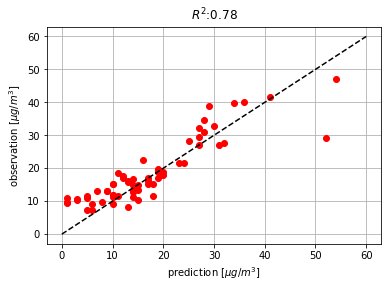

In [85]:
plt.plot(y_test.values, yst_prediction,'ro');plt.plot([0,60],[0,60],'--k');
plt.xlabel('prediction [$\mu g/m^3$]');plt.ylabel('observation [$\mu g/m^3$]')
r2s =r2_score(y_true=y_test, y_pred=yst_prediction)
plt.title('$R^2$:%.2f'%r2s)
plt.grid()
plt.show()
 

# Understanding the Results of an Regression Analysis <span style='color:blue'>(Reference)</span>
[Stats Model : statistics in Python](http://www.statsmodels.org/dev/examples/index.html#regression)
 
## Descriptive Statistics for Variables

**statmodels** prints a variety of statistics at the end of each analysis. For each variable, NLREG lists the minimum value, the maximum value, the mean value, and the standard deviation. You should confirm that these values are within the ranges you expect.
Parameter Estimates

For each parameter, analysis displays the initial parameter estimate (which you specified on the PARAMETER statement, or 1 by default), the final (maximum likelihood) estimate, the standard error of the estimated parameter value, the "t'' statistic comparing the estimated parameter value with zero, and the significance of the t statistic.  Nine significant digits are displayed for the parameter estimates.  If you need to determine the parameters to greater precision, use the POUTPUT statement.
 
The final estimate parameter values are the results of the analysis. By substituting these values in the equation you specified to be fitted to the data, you will have a function that can be used to predict the value of the dependent variable based on a set of values for the independent variables.  For example, if the equation being fitted is
 
** y = p0 + p1*x **
 
and the final estimates are 1.5 for p0 and 3 for p1, then the equation
 
**y = 1.5 + 3*x **
 
is the best equation of this form that will predict the value of y based on the value of x.
 
**t Statistic**

The "t'' statistic is computed by dividing the estimated value of the parameter by its standard error.  This statistic is a measure of the likelihood that the actual value of the parameter is not zero. The larger the absolute value of t, the less likely that the actual value of the parameter could be zero.
Prob(t)

** Prob(t) **

The "Prob(t)'' value is the probability of obtaining the estimated value of the parameter if the actual parameter value is zero.  The smaller the value of Prob(t), the more significant the parameter and the less likely that the actual parameter value is zero.  For example, assume the estimated value of a parameter is 1.0 and its standard error is 0.7.  Then the t value would be 1.43 (1.0/0.7).  If the computed Prob(t) value was 0.05 then this indicates that there is only a 0.05 (5%) chance that the actual value of the parameter could be zero.  If Prob(t) was 0.001 this indicates there is only 1 chance in 1000 that the parameter could be zero.  If Prob(t) was 0.92 this indicates that there is a 92% probability that the actual value of the parameter could be zero; this implies that the term of the regression equation containing the parameter can be eliminated without significantly affecting the accuracy of the regression.
 
One thing that can cause Prob(t) to be 1.00 (or near 1.00) is having redundant parameters.  If at the end of an analysis several parameters have Prob(t) values of 1.00, check the function carefully to see if one or more of the parameters can be removed. Also try using a DOUBLE statement to set one or more of the parameters to a reasonable fixed value; if the other parameters suddenly become significant (i.e., Prob(t) much less than 1.00) then the parameters are mutually dependent and one or more should be removed.
 
The t statistic probability is computed using a two-sided test.  The CONFIDENCE statement can be used to cause NLREG to print confidence intervals for parameter values.  The SQUARE.NLR example regression includes an extraneous parameter (p0) whose estimated value is much smaller than its standard error; the Prob(t) value is 0.99982 indicating that there is a high probability that the value is zero.
Final Sum of Squared Deviations

In addition to the variable and parameter values, NLREG displays several statistics that indicate how well the equation fits the data.  The "Final sum of squared deviations'' is the sum of the squared differences between the actual value of the dependent variable for each observation and the value predicted by the function, using the final parameter estimates.
Average and Maximum Deviation

** Average deviation ** 

The "Average deviation'' is the average over all observations of the absolute value of the difference between the actual value of the dependent variable and its predicted value.

** Maximum deviation **

The "Maximum deviation for any observation'' is the maximum difference (ignoring sign) between the actual and predicted value of the dependent variable for any observation.
Proportion of Variance Explained

** R2 **

The "Proportion of variance explained (R2)'' indicates how much better the function predicts the dependent variable than just using the mean value of the dependent variable.  This is also known as the "coefficient of multiple determination.''  It is computed as follows: Suppose that we did not fit an equation to the data and ignored all information about the independent variables in each observation.  Then, the best prediction for the dependent variable value for any observation would be the mean value of the dependent variable over all observations.  The "variance'' is the sum of the squared differences between the mean value and the value of the dependent variable for each observation.  Now, if we use our fitted function to predict the value of the dependent variable, rather than using the mean value, a second kind of variance can be computed by taking the sum of the squared difference between the value of the dependent variable predicted by the function and the actual value.  Hopefully, the variance computed by using the values predicted by the function is better (i.e., a smaller value) than the variance computed using the mean value.  The "Proportion of variance explained'' is computed as 1 – (variance using predicted value / variance using mean).  If the function perfectly predicts the observed data, the value of this statistic will be 1.00 (100%).  If the function does no better a job of predicting the dependent variable than using the mean, the value will be 0.00.

**Adjusted Coefficient of Multiple Determination **

The "adjusted coefficient of multiple determination (Ra2)'' is an R2 statistic adjusted for the number of parameters in the equation and the number of data observations.  It is a more conservative estimate of the percent of variance explained, especially when the sample size is small compared to the number of parameters. 

** The "Durbin-Watson Statistic for autocorrelation **

The "Durbin-Watson test for autocorrelation'' is a statistic that indicates the likelihood that the deviation (error) values for the regression have a first-order autoregression component.  The regression models assume that the error deviations are uncorrelated.
 
In business and economics, many regression applications involve time series data.  If a non-periodic function, such as a straight line, is fitted to periodic data, the deviations have a periodic form and are positively correlated over time; these deviations are said to be "autocorrelated'' or "serially correlated.''  Autocorrelated deviations may also indicate that the form (shape) of the function being fitted is inappropriate for the data values (e.g., a linear equation fitted to quadratic data).
 
If the deviations are autocorrelated, there may be a number of consequences for the computed results: 1) The estimated regression coefficients no longer have the minimum variance property; 2) the mean square error (MSE) may seriously underestimate the variance of the error terms; 3) the computed standard error of the estimated parameter values may underestimate the true standard error, in which case the t values and confidence intervals may be incorrect.  Note that if an appropriate periodic function is fitted to periodic data, the deviations from the regression will be uncorrelated because the cycle of the data values is accounted for by the fitted function.
 
**Small values of the Durbin-Watson statistic indicate the presence of autocorrelation.  Consult significance tables in a good statistics book for exact interpretations; however, <span style='color:red'>a value less than 0.80</span> usually indicates that autocorrelation is likely.**  If the Durbin-Watson statistic indicates that the residual values are autocorrelated, it is recommended that you use the RPLOT and/or NPLOT statements to display a plot of the residual values.
 
If the data has a regular, periodic component you can try including a sin term in your function.  The TREND.NLR example fits a function with a sin term to data that has a linear growth with a superimposed sin component.  With the sin term the function has a residual value of 29.39 and a Durbin-Watson value of 2.001; without the sin term (i.e., fitting only a linear function) the residual value is 119.16 and the Durbin-Watson value is 0.624 indicating strong autocorrelation.  The general form of a sin term is
amplitude * sin(2*pi*(x-phase)/period)

where amplitude is a parameter that determines the magnitude of the sin component, period determines the period of the oscillation, and phase determines the phase relative to the starting value.  If you know the period (e.g., 12 for monthly data with an annual cycle) you should specify it rather than having NLREG attempt to determine it.
 
If an NPLOT statement is used to produce a normal probability plot of the residuals, the correlation between the residuals and their expected values (assuming they are normally distributed) is printed in the listing.  If the residuals are normally distributed, the correlation should be close to 1.00.  A correlation less than 0.94 suggests that the residuals are not normally distributed.
Analysis of Variance Table

An "Analysis of Variance'' table provides statistics about the overall significance of the model being fitted.
 
** F Value and Prob(F) **
 
The "F value'' and "Prob(F)'' statistics test the overall significance of the regression model.  Specifically, they test the null hypothesis that all of the regression coefficients are equal to zero.  This tests the full model against a model with no variables and with the estimate of the dependent variable being the mean of the values of the dependent variable.  The F value is the ratio of the mean regression sum of squares divided by the mean error sum of squares.  Its value will range from zero to an arbitrarily large number.
 
The value of Prob(F) is the probability that the null hypothesis for the full model is true (i.e., that all of the regression coefficients are zero).  For example, if Prob(F) has a value of 0.01000 then there is 1 chance in 100 that all of the regression parameters are zero.  This low a value would imply that at least some of the regression parameters are nonzero and that the regression equation does have some validity in fitting the data (i.e., the independent variables are not purely random with respect to the dependent variable).
Correlation Matrix

The CORRELATE statement can be used to cause NLREG to print a correlation matrix.  A "correlation coefficient'' is a value that indicates whether there is a linear relationship between two variables.  The absolute value of the correlation coefficient will be in the range 0 to 1.  A value of 0 indicates that there is no relationship whereas a value of 1 indicates that there is a perfect correlation and the two variables vary together.  The sign of the correlation coefficient will be negative if there is an inverse relationship between the variables (i.e., as one increases the other decreases).
 
For example, consider a study measuring the height and weight of a group of individuals.  The correlation coefficient between height and weight will likely have a positive value somewhat less than one because tall people tend to weigh more than short people.  A study comparing number of cigarettes smoked with age at death will probably have a negative correlation value.
 
A correlation matrix shows the correlation between each pair of variables.  The diagonal of the matrix has values of 1.00 because a variable always has a perfect correlation with itself.  The matrix is symmetric about the diagonal because X correlated with Y is the same as Y correlated with X.
 
** Problems of correlation between independant variables **

>Problems occur in regression analysis when a function is specified that has multiple independent variables that are highly correlated.  The common interpretation of the computed regression parameters as measuring the change in the expected value of the dependent variable when the corresponding independent variable is varied while all other independent variables are held constant is not fully applicable when a high degree of correlation exists.  This is due to the fact that with highly correlated independent variables it is difficult to attribute changes in the dependent variable to one of the independent variables rather than another.  The following are effects of fitting a function with high correlated independent variables:
 
1.         Large changes in the estimated regression parameters may occur when a variable is added or deleted, or when an observation is added or deleted.
 
2.         Individual tests on the regression parameters may show the parameters to be nonsignificant.
 
3.         Regression parameters may have the opposite algebraic sign than expected from theoretical or practical considerations.
 
4.         The confidence intervals for important regression parameters may be be much wider than would otherwise be the case.  The solution to these problems may be to select the most significant of the correlated variables and use only it in the function.
 
** Note: the correlation coefficients indicate the degree of linear association between variables. Variables may be highly related in a nonlinear fashion and still have a correlation coefficient near 0. **

 ## Test for multicollinearity**  <span style='color:blue'>(reference)</span>

It is also possible that correlations exist between our predictors. This is a condition known as multicollinearity, and this has the potential to make our results invalid. Therefore, we test for this condition using a Variance Inflation Factor (VIF) test. If our VIF statistic > 10, then there exists an issue with multicollinearity.

To do this, we run a VIF on the reg1 regression model that we created. The Variance Inflation Factor is calculated as follows:

VIF = $\frac{1}{(1-R^2)}$

For below example , x1 and x3 are correlated.

In [86]:
def testVIF():
   
    # create datasets ; x1 and x2 are correlated
    x1=np.array([1,1,2,3,4])
    x2=np.array([2,2,3,2,1])
    x3=np.array([4,6,7,8,9])
    x4=np.array([4,3,4,5,4])
    xt = np.column_stack((x1,x2,x3,x4))
    xt_df = pd.DataFrame(xt, columns=['x1','x2','x3','x4'])
    y = 1.1*x1 + 2.4*x2 + 5.5*x3 + 9.9*x4
    
    #create
    yy,xx = dmatrices('y~x1+x2+x3+x4',data=xt_df, return_type='dataframe')
    
    # fit x to y
    result=sm.OLS(yy,xx).fit()
    #print(result.summary())

    # create empty dataframe
    vif=pd.DataFrame()
    
    # calculate variance_inflation_factor
    vif['vif factor'] = [variance_inflation_factor(xx.values,i) \
                        for i in range(xx.shape[1]) ]
    vif['features'] = xx.columns
    print('**vif **')
    print(vif.round(2))

testVIF()

**vif **
   vif factor   features
0      136.87  Intercept
1       22.95         x1
2        3.00         x2
3       12.95         x3
4        3.00         x4


## Regression :  Ordinary Least Square(OLS) -baseline model

scikit-learn linear regression is used for baseline data.


### Comparision of Linear Regressor for case I and case II

#### Case I :  Input1(Xc), we will only consider Sharp-measured voltage[milivolt].

In [87]:
regression_model = LinearRegression()

In [88]:
regression_model.fit(Xc_train, yc_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

> **Scoring model**

> A common method of measuring the accuracy of regression models is to use the $R^2$ statistic.
The $R^2$ statistic is defined as follows:

>$R^2$=1–$\frac{RSS}{TSS}$
The RSS (Residual sum of squares) measures the variability left unexplained after performing the regression.The TSS measues the total variance in Y.
Therefore the **$R^2$ statistic measures proportion of variability in Y that is explained by X using our model**. $R^2$ can be determined using our test set and the model’s score method.

Trained model $R^2$ score

In [24]:
R2_train_case1 = regression_model.score(Xc_train, yc_train)
R2_train_case1

0.6975398596618908

Test model $R^2$ score

In [25]:
R2_test_case1 = regression_model.score(Xc_test, yc_test)
R2_test_case1

0.5657574947379763

So in our model, 70.04% of the variability in y can be explained using Xc

** Root Mean Squared Error **

In [26]:
yc_predict_train = regression_model.predict(Xc_train)
yc_predict = regression_model.predict(Xc_test)

regression_model_mse = mean_squared_error(yc_predict, yc_test)

rms_error1 = math.sqrt(regression_model_mse)
print('rms:%.1f' %rms_error1)

rms:6.3


So we are an average of {{rms_error1}} $\mu$g/$m^3$ away from the ground truth PM2.5 concentration when making predictions on our test set.


#### Case II :
Analysis was not carried out because legitimate comparison between the case I and II can be made in K-Fold cross validation.

In [27]:
regression_model.fit(X_train, y_train)
R2_train_case2 = regression_model.score(X_train, y_train)
R2_test_case2 = regression_model.score(X_test, y_test)
y2_predict_train = regression_model.predict(X_train)
y2_predict = regression_model.predict(X_test)
regression_model_mse2 = mean_squared_error(y2_predict, y_test)
rms_error2 = math.sqrt(regression_model_mse2)
print('rms:%3.2f' %rms_error1)
print('R2-train - caseII  :%.2f'%R2_train_case2)
print('R2-test  - caseII  :%.2f'%R2_test_case2)
print('rms-caseII         :%.2f' %rms_error2)

rms:6.27
R2-train - caseII  :0.78
R2-test  - caseII  :0.71
rms-caseII         :5.95


### K-fold Cross-validation of Linear Regressor for Case I and II

__K-Folds Cross Validation__

In K-Folds Cross Validation, we split our data into k different subsets (or folds). We use k-1 subsets to train our data and leave the last subset (or the last fold) as test data. We then average the model against each of the folds and then finalize our model. After that we test it against the test set.<br>



#### Case I : Linear Regression with only measurement of portable device 

In [28]:
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut 
from sklearn.model_selection import cross_val_score

# K-Fold Cross Validation
# X must be numpy array if X is Pandas DataFrame, use X.values instead. 
def crossValidationKFold(X,y,kfold=10):
    k_fold = KFold(n_splits=kfold,shuffle=True)
    rmse =[]
    R2 = []
    mean_y_test =[]
    for train,test in k_fold.split(X):
        regression_model.fit(X[train],y[train])
        # R2
        R2cv = regression_model.score(X[test],y[test])
        # make a list of R2
        R2.append(R2cv)
        
        # calculate mean of y[test]
        mean_ytest = np.mean(y[test])
        # make a list of mean of y[test]
        mean_y_test.append(mean_ytest)
        
        # calculate mse
        y_predicted=regression_model.predict(X[test])
        mse = mean_squared_error(y_predicted, y[test])
        # make list of mse
        rmse.append(math.sqrt(mse))
       
    # covert python list to numpy array    
    R2_np = np.array(R2)
    rmse_np = np.array(rmse)
    mean_y_test_np = np.array(mean_y_test)
    
    # print 
    print ('%s '%(kf_cv) + 'fold Cross Validation Result ------')
    print ('R2 mean        :%5.2f, std:%5.2f' %(R2_np.mean(),R2_np.std()))
    print ('rmse mean       :%5.2f, std:%5.2f'  \
            %(rmse_np.mean(),rmse_np.std()))
    print('mean of y_test : %.2f' %(mean_y_test_np.mean()))
    
    # return rms error and R2
    return {'rmse' : rmse_np, 'R2' : R2_np, 'mean_y_test' : mean_y_test_np}

def crossValLOO(Xc):
     for train,test in loo.split(Xc):
        tr=regression_model.fit(Xc[train],y[train])
        y_predicted=regression_model.predict(Xc[test])
        mse = mean_squared_error(y_predicted, y[test])
        rmse = math.sqrt(mse)
        print('square-root of mse: %5.2f' %rmse)
kf_cv =10
kFoldCV1 = crossValidationKFold(Xc,y,kfold=kf_cv)

10 fold Cross Validation Result ------
R2 mean        : 0.63, std: 0.14
rmse mean       : 6.55, std: 0.78
mean of y_test : 18.16


#####  Analysis of K-Fold Mean of RMSE
{{kf_cv}}-Fold mean of root mean square error(rmse) is {{kFoldCV1['rmse'].mean()}}, which is {{kFoldCV1['rmse'].mean()/kFoldCV1['mean_y_test'].mean()*100}} % of K-Fold mean of y_test ({{kFoldCV1['mean_y_test'].mean()}})

#### Case II : Linear Regression with measurement of portable device, temperature, humidity
Regression model includes temperature and humidity along with measurement of portable PM2.5 measuring device.

In [29]:
# fit model to data
regression_model.fit(X_train, y_train)

# calculate R2 (coefficient of determination)
R2_train_case2 = regression_model.score(X_train, y_train)
R2_test_case2  = regression_model.score(X_test, y_test)

# predict output
y2_predict = regression_model.predict(X_test)

# calculate root-mean-squared-error(rms)
regression_model_mse = mean_squared_error(y2_predict, y_test)
rms_error2 = math.sqrt(regression_model_mse)

# print results
print('train model score(R2)  : %5.2f' % R2_train_case2)
print('test  model score(R2)  : %5.2f' % R2_test_case2)
print('RMS error              : %5.2f' % rms_error2)

#K-fold cross validation
kFoldCV2 = crossValidationKFold(X.values,y,kfold=kf_cv)



train model score(R2)  :  0.78
test  model score(R2)  :  0.71
RMS error              :  5.95
10 fold Cross Validation Result ------
R2 mean        : 0.73, std: 0.08
rmse mean       : 5.60, std: 1.09
mean of y_test : 18.16


** Correlation Plot for train data sets ** <span style="color:red" >[FIGURE FOR PAPER]</span>

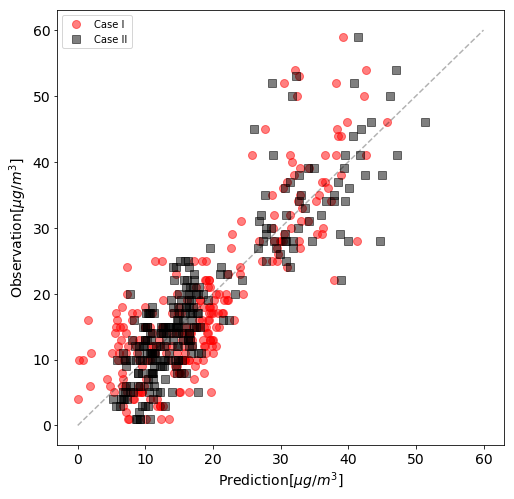

In [30]:
plotFontSize=14
plt.figure(figsize=(8,8))
plt.plot(yc_predict_train,yc_train.values,'ro',ms=8,alpha=0.5,label='Case I')
plt.plot(y2_predict_train,y_train.values,'ks',ms=8,alpha=0.5,label='Case II')

#plt.plot(Xc_train,yc_train.values,'ro',ms=8,alpha=0.5,label='Case I')
#plt.plot(X_train.iloc[:,0],y_train.values,'ks',ms=8,alpha=0.5,label='Case II')


plt.plot([0,60],[0,60],'--k',alpha=0.3)
plt.xlabel('Prediction[$\mu g/m^3$]',fontsize=plotFontSize)
plt.ylabel('Observation[$\mu g/m^3$]',fontsize=plotFontSize)
#plt.title('Regression using Linear Regressor')
plt.grid(False)
plt.legend()
plt.tick_params(labelsize = plotFontSize)

if savefig:
    plt.savefig('./fig_Regression/LinearRegressionCorrelation_Train.png', dpi=600,bbox_inches='tight')
plt.show()

** Correlation Plot for test data sets ** <span style="color:red" >[FIGURE FOR PAPER]</span>

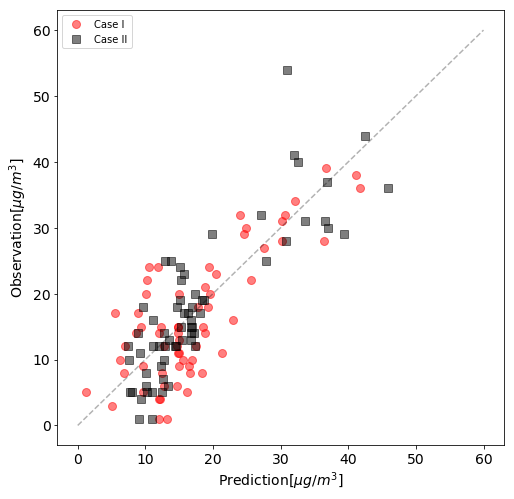

In [31]:
plotFontSize=14
plt.figure(figsize=(8,8))
plt.plot(yc_predict,yc_test.values,'ro',ms=8,alpha=0.5,label='Case I')
plt.plot(y2_predict,y_test.values,'ks',ms=8,alpha=0.5,label='Case II')

plt.plot([0,60],[0,60],'--k',alpha=0.3)
plt.xlabel('Prediction[$\mu g/m^3$]',fontsize=plotFontSize)
plt.ylabel('Observation[$\mu g/m^3$]',fontsize=plotFontSize)
#plt.title('Regression using Linear Regressor')
plt.grid(False)
plt.legend()
plt.tick_params(labelsize = plotFontSize)

if savefig:
    plt.savefig('./fig_Regression/LinearRegressionCorrelation_Test.png', dpi=600,bbox_inches='tight')
plt.show()

#### Comparison between case I and II based on K-fold cross validation

In [32]:
gain0 = (R2_train_case2 - R2_train_case1)/R2_train_case1 * 100
gain1 = (R2_test_case2 - R2_test_case1)/R2_test_case1 * 100
gain2 = (rms_error1 - rms_error2)/rms_error1 * 100
gain3 = (kFoldCV2['R2'].mean()-kFoldCV1['R2'].mean())/kFoldCV1['R2'].mean() *100
gain4 = (kFoldCV1['rmse'].mean()-kFoldCV2['rmse'].mean())/kFoldCV1['rmse'].mean() *100


print('R2 increase(train)           : %5.0f [%%]' % gain0 )
print('R2 increase(test)            : %5.0f [%%]' % gain1 )
print('RMS error decrease           : %5.0f [%%]' % gain2 )
print('R2(k-fold) increase          : %5.0f [%%]' % gain3 )
print('RMS(k-fold) error decrease   : %5.0f [%%]' % gain4 )



R2 increase(train)           :    12 [%]
R2 increase(test)            :    25 [%]
RMS error decrease           :     5 [%]
R2(k-fold) increase          :    16 [%]
RMS(k-fold) error decrease   :    14 [%]


{{gain0}}

----
#### Comparison between Case I and Case II<br>

|input|train $R^2$|test $R^2$|test RMS error $\frac{\mu g}{m^3}$|{{kf_cv}}-fold $R^2$|{{kf_cv}}-fold RMS error|
|:---|:--------------:|------------:|------------:|------:|-------:|
|case1($X_c$)|{{R2_train_case1}}|{{R2_test_case1}}|{{rms_error1}}|{{kFoldCV1['R2'].mean()}}|{{kFoldCV1['rmse'].mean()}}|
|case2($X$)|{{R2_train_case2}}|{{R2_test_case2}}|{{rms_error2}}|{{kFoldCV2['R2'].mean()}}|{{kFoldCV2['rmse'].mean()}}|
|gain[%]|{{gain0}}|{{gain1}}|{{gain2}}|**{{gain3}}**|**{{gain4}}**|


With temperature and humidity included in the regression model(Case II), RMS error caculated by K-fold cross validation(no. of folds = {{kf_cv}}) is decreased by {{gain3}} % and $R^2$ increased by {{gain4}} %. 

Mean of test_y for case I and II was {{kFoldCV1['mean_y_test'].mean()}} $\mu g/m^3$.

RMSE of Case I is {{kFoldCV1['rmse'].mean()/kFoldCV1['mean_y_test'].mean() *100}} % of mean test_y.

RMSE of Case II is {{kFoldCV2['rmse'].mean()/kFoldCV2['mean_y_test'].mean() *100}} % of mean test_y.



Intentionally blank cell

#### T - test of Case 1 and Case 2
Calculate the T-test for the means of two independent samples of scores.

This is a two-tailed(two-sided) test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.

The result is two-tailed p-value.

In [33]:
from scipy import stats

n1 = kFoldCV1['R2'];
n2 = kFoldCV2['R2']
t_R2, p_R2 = stats.ttest_ind(n1,n2)
print('Two Sample T-test for R2 ==> t-r2:%3.2f p-r2:%3.2f' %(t_R2,p_R2))

n1 = kFoldCV1['rmse'];
n2 = kFoldCV2['rmse']
t_rms, p_rms = stats.ttest_ind(n1,n2)
print('Two Sample T-test for RMSE ==> t-rms:%3.2f p-rms:%3.2f' %(t_rms,p_rms))

Two Sample T-test for R2 ==> t-r2:-1.87 p-r2:0.08
Two Sample T-test for RMSE ==> t-rms:2.11 p-rms:0.05


## Plot the results

#### comparison plot between observed and predicted : Linear Regression
First Sort

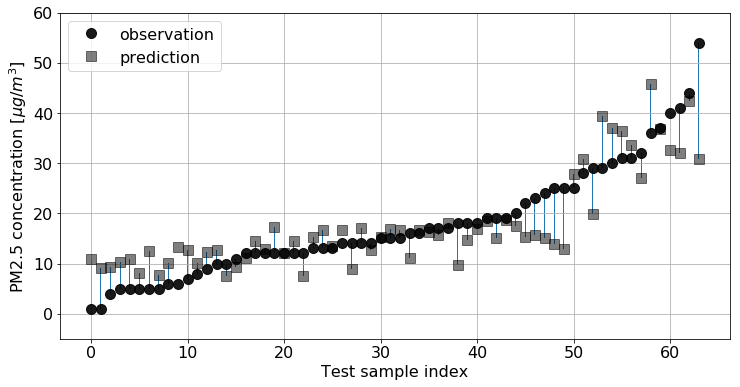

In [34]:
# sort data
df = pd.DataFrame({'observe':y_test.values, 'predict':y2_predict})
df.sort_values(by=['observe'],inplace=True)
plt.figure(figsize=(12,6))
xData = np.arange(y_test.shape[0])
plt.plot(xData,df['observe'],'ko',alpha=0.9,lw=1,ms=10,label='observation')
plt.plot(xData,df['predict'],'ks',alpha=0.5,ms=10,label='prediction')
plt.legend(fontsize=16,loc=2)
plt.ylabel('PM2.5 concentration [$\mu g/m^3$]',fontsize=16)
plt.xlabel('Test sample index',fontsize=16)
plt.ylim(-5,60)
plt.tick_params(labelsize = 16)
plt.bar(xData,df['observe']-df['predict'],bottom=df['predict'],width=0.1)
if savefig:
    plt.savefig('./fig_Regression/LinearRegressionPerfomance.png', dpi=600,bbox_inches='tight')
plt.grid()
plt.show()


#### Residual plot for Linear Regression
Residual plots are a good way to visualize the errors in data. If you see structure in your data, that means your model is not capturing some thing, Maybe there is a interaction between 2 variables that you are not considering, or may be you are measuring time dependant data. If there are some structure in your data,your model should be checked again. This random pattern indicates that a linear model provides a decent fit to the data. Before you look at the statistical measures for goodness-of-fit, you should check the residual plots. Residual plots can reveal unwanted residual patterns that indicate biased results more effectively than numbers. When your residual plots pass muster, you can trust your numerical results and check the goodness-of-fit statistics.

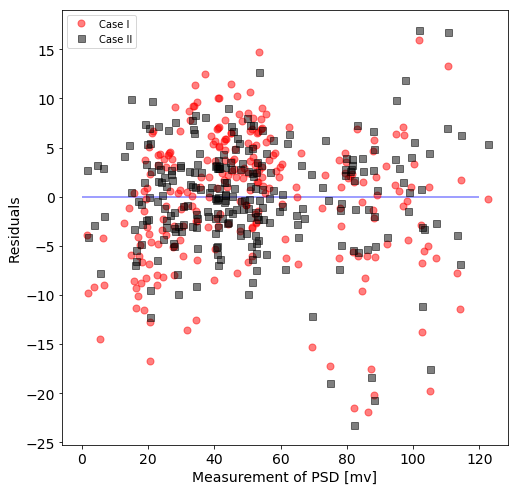

In [35]:
plt.figure(figsize=(8,8))

plt.plot(Xc_train, yc_predict_train - yc_train.values, 'ro', ms=7, alpha=0.5,label='Case I')
plt.plot(X_train.iloc[:,0], y2_predict_train - y_train.values, 'ks', ms=7, alpha=0.5,label='Case II')
#plt.scatter(X_test['mpd'], rf['Residual-test'], marker='s',c='k', s=30, alpha = 0.5)
plt.hlines(y=0, xmin=0,xmax=120, alpha=0.5, color='b')
plt.xlabel('Measurement of PSD [mv]',fontsize=14)
plt.ylabel('Residuals',fontsize=14)
plt.tick_params(labelsize = 14)
#plt.title('Residual Plot')
plt.legend()


if savefig:
    plt.savefig('./fig_Regression/LinearRegressionResidual.png', dpi=600,bbox_inches='tight')
plt.show()

In [36]:
X_train

,mpd,humidity,temperature
311,23.1,52.8,12.4
20,101.8,82.5,20.8
297,38.2,74.0,12.9
60,41.0,75.6,18.5
10,82.2,92.2,17.2
30,92.0,84.3,19.5
310,25.9,54.6,13.0
278,29.5,18.7,14.6
206,52.2,68.4,19.3
91,48.9,72.3,19.4


------------------------------------------------------------
### Random forest regressor
------------------------------------------------------------

#### Random forest regression

In [37]:


def RandomForestRegression(X_train,X_test,y_train,y_test,n_estimator,verbose=1):
   
    rf = RandomForestRegressor(n_estimators=n_estimator, oob_score=True,min_samples_leaf=5 )
    
    rf.fit(X_train, y_train)
    # prediction
    predictedFromTrainData = rf.predict(X_train)
    predictedFromTestData = rf.predict(X_test)
    # R2 (coefficient of determination)
    R2FromTestDataUsingRandomForest = r2_score(y_test, predictedFromTestData)
    # out of bag R2
    R2FromOutOfBagTest = rf.oob_score_
    # RMS error
    RMSbyRandomForest = math.sqrt(mean_squared_error(predictedFromTestData, y_test))
    #spearman = spearmanr(y_test, predicted_test)
    #pearson = pearsonr(y_test, predicted_test)
    
    # Residual
    ResidualTrain = predictedFromTrainData - y_train
    ResidualTest  = predictedFromTestData - y_test
    
    # print result
    if verbose:
        print ('--------------------------------------------------------------------------')
        print(rf)
        print('Out-of-bag R2 estimate      : %5.2f' %R2FromOutOfBagTest)
        print('Test data R2                : %5.2f' %R2FromTestDataUsingRandomForest)
        print('RMS error                   : %5.2f' %RMSbyRandomForest)
        #print('Test data Spearman correlation:%5.2f' %spearman[0])
        #print('Test data Pearson correlation:%5.2f' %pearson[0])
    
    # return outputs
    return {'R2-oob':R2FromOutOfBagTest,'R2-test':R2FromTestDataUsingRandomForest,\
            'RMS':RMSbyRandomForest,\
            'prediction-train':predictedFromTrainData,'prediction-test':predictedFromTestData,\
            'Residual-train':ResidualTrain,'Residual-test':ResidualTest}
 
# Run Random Forest Regressor no. of trees = 100
rf=RandomForestRegression(X_train,X_test,y_train,y_test,n_estimator=200, verbose=1)

# Compare Linear and Random Forest Regressor
R2change =  (rf['R2-test'] -kFoldCV2['R2'].mean()) / kFoldCV2['R2'].mean() * 100
RMSchange = (kFoldCV2['rmse'].mean() -  rf['RMS'] ) /  kFoldCV2['rmse'].mean() * 100
print ('----- Comparison between Linear Regressor and Random Forest -----------')
print('R2 comparision(LR/RF)%%: %5.1f' %R2change)
print('RMS comparision(LF/RF)%%: %5.1f' %RMSchange)

--------------------------------------------------------------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=True, random_state=None, verbose=0, warm_start=False)
Out-of-bag R2 estimate      :  0.79
Test data R2                :  0.77
RMS error                   :  5.30
----- Comparison between Linear Regressor and Random Forest -----------
R2 comparision(LR/RF)%:   5.2
RMS comparision(LF/RF)%:   5.4


#### Comparison between Linear Regressor and Random Forest regressor

Compared to Linear Regressor, Random Forest Regressor produced {{R2change}} % increase in $R^2$ and {{RMSchange}} % decrease in RMS error.

|Method|$R^2$-oob|$R^2$-test|RMS error|
|:---------------:|:-----------------:|:-------:|:--:|
|Linear Regresssor|-|{{kFoldCV2['R2'].mean()}}|{{kFoldCV2['rmse'].mean()}}|
|Random Forest|{{rf['R2-oob']}}|{{rf['R2-test']}}|{{rf['RMS']}}|
|change[%]|-|{{R2change}}|{{RMSchange}}|

### K-fold comparison of machine learning regression classifiers

K Fold cross-validation in regard to $R^2$ and RMSE of different regression algorithms including linear regression, random forest, support vector machine, K-nearest neighbor, XGB regressors. 

/home/brian/keras_tf/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


95% confidence interval of mean of auc : T distribution
R2-mean:0.76,confidendce interval-LR:0.74-0.77
R2-mean:0.72,confidendce interval-SVM:0.70-0.74
R2-mean:0.77,confidendce interval-RF:0.75-0.80
R2-mean:0.75,confidendce interval-KNN:0.73-0.78
R2-mean:0.82,confidendce interval-XGB:0.80-0.84
RMSE-mean:5.67,confidendce interval-LR:5.47-5.87
RMSE-mean:6.08,confidendce interval-SVM:5.84-6.31
RMSE-mean:5.40,confidendce interval-RF:5.21-5.60
RMSE-mean:5.63,confidendce interval-KNN:5.45-5.81
RMSE-mean:4.81,confidendce interval-XGB:4.58-5.05


<Figure size 720x576 with 0 Axes>

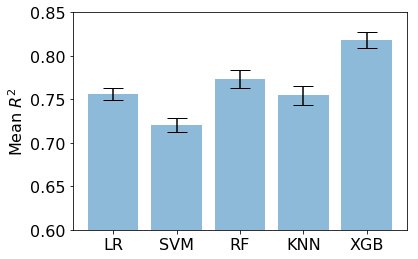

<Figure size 720x576 with 0 Axes>

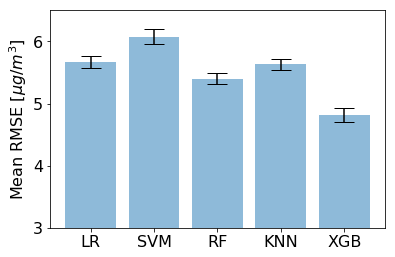

** Compare the best machine learning algorithm with Linear Regression **
8.27 % increase in mean-R2
15.08 % decrease in mean-rmse 

** Compare rmse of XGB with mean y_test **
mean of y_test:18.16, mean of rmse-xgb: 4.81
mean of rmse of xgb is 26.5 % of mean of y_test


In [38]:
from sklearn.model_selection import StratifiedKFold, KFold
from scipy import stats
from sklearn import svm # support vector machine
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier, XGBRegressor
#from scipy import interp
from sklearn.svm import SVR # support vector regression


def KFoldCrossValidation(X_in,Y_in,kfold):
    # shuffle before choosing
    kf = KFold(n_splits=kfold, shuffle=True, random_state=None).split(X_in)
    
    # create classifier
    clf_lr = LinearRegression()
    clf_rf = RandomForestRegressor(bootstrap=True, min_samples_leaf=5)
    clf_svm = svm.SVR(kernel='linear',C=1e-3) # support vector machine regression
    clf_knn = KNeighborsRegressor(n_neighbors=5)
    clf_xgb = XGBRegressor()
    
     # R2 and mse array
    R2_array_lr =[]
    R2_array_rf =[] # ROC model randmom forest
    R2_array_svm =[] # support vector machine
    R2_array_xgb=[]
    R2_array_knn=[]
    mse_array_lr =[]
    mse_array_rf =[] # linear regression
    mse_array_svm =[] # gausian naive
    mse_array_xgb=[]
    mse_array_knn=[]
    
    # mean of y_test array for rmse comparison
    mean_y_test_array =[]
    
    
    # accuracy array
    acc_array =[]
    sens_array = []
    speci_array = []
    
   
    # 6 times repetition which result in 5x6 = 30 data sets 
    repetition = 6
    for _ in range(repetition):
    
        for train_index, test_index in kf:
            X_train, X_test = X_in[train_index], X_in[test_index]
            y_train, y_test = Y_in[train_index], Y_in[test_index] 
        
        # add mean of y_test to array
            mean_y_test_array.append(y_test.mean())
        
        # make a function for roc plot
            clf_lists = [(clf_lr,R2_array_lr,mse_array_lr,'LR'),(clf_svm,R2_array_svm,mse_array_svm,'SVM'),\
                         (clf_rf,R2_array_rf,mse_array_rf,'RF'),(clf_knn,R2_array_knn,mse_array_knn,'KNN'),\
                         (clf_xgb,R2_array_xgb,mse_array_xgb,'XGB') \
                        ]
            for clf,R2,MSE,name in clf_lists :
                y_pred = clf.fit(X_train,y_train).predict(X_test)
                R2Val  = clf.score(X_test, y_test)
                mseVal = mean_squared_error(y_pred, y_test)
                #print('R2-%s: %5.2f, MSE-%s:%5.2f' %(name,R2Val,name,mseVal))         
                # add auc to array    
                R2.append(R2Val)
                MSE.append(mseVal)
        
    # calculation of confiden interval    
    #mean = np.mean(auc_array)
    #std = np.std(auc_array)
    #print('auc of %3.2f [95%% CI: %3.2f - %3.2f]' %(mean,mean-2*std,mean+2*std)) 
    # confidence level using stats mode
    
    #print('95% confidence interval of mean of auc : Normal distribution')
    #for clf,tprs,aucs,name in roc_lists:
    #    conf_int = stats.norm.interval(0.95, loc=np.mean(aucs), scale=np.std(aucs)/np.sqrt(kfold*repetition))
    #    print('mean:%3.2f,confidendce interval-%s:%3.2f-%3.2f' %(np.mean(aucs),name,conf_int[0],conf_int[1]))
    
    print('95% confidence interval of mean of auc : T distribution')
    # degree of freedom(dof) = No. of samples - 1
    dof = kfold*repetition-1
    for clf,R2,mse,name in clf_lists:
       conf_int = stats.t.interval(0.95,df=dof, loc=np.mean(R2), scale=np.std(R2)/np.sqrt(kfold*repetition))
       print('R2-mean:%3.2f,confidendce interval-%s:%3.2f-%3.2f' %(np.mean(R2),name,conf_int[0],conf_int[1]))
    
    for clf,R2,mse,name in clf_lists:
       rmse = np.sqrt(mse)
       conf_int = stats.t.interval(0.95,df=dof, loc=np.mean(rmse), scale=np.std(rmse)/np.sqrt(kfold*repetition))
       print('RMSE-mean:%3.2f,confidendce interval-%s:%3.2f-%3.2f' %(np.mean(rmse),name,conf_int[0],conf_int[1]))
    
    # error bar plot for R2
    # Create Arrays for the plot
    # mean and standard error of auc
    mean_R2 = [ np.mean(R2) for clf,R2,mse,name in clf_lists] # mean
    std_R2 = [ np.std(R2) for clf,R2,mse,name in clf_lists] # standard deviaion
    se_R2 = std_R2 / np.sqrt(kfold*repetition) # standard error
    
    classifiers = [ name for clf,R2,mse,name in clf_lists]
    x_pos = np.arange(len(classifiers))
    
    # Build the plot  
    plt.figure(figsize=(10,8))
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_R2, yerr=se_R2, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Mean $R^2$',fontsize=16)
    ax.set_xticks(x_pos)
    plt.tick_params(labelsize=16)
    ax.set_xticklabels(classifiers)
    #ax.set_title('AUC')
    ax.set_ylim(0.6,0.85)
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    # Save the figure and show
    saveFig = True
    if saveFig == True:
        plt.savefig('./fig_Regression/R2_error_barplot.png', dpi=600,bbox_inches='tight')
    plt.show()
    
    # error bar plot for RMSE
    # Create Arrays for the plot
    # mean and standard error of auc
    mean_rmse = [ np.mean(np.sqrt(mse)) for clf,R2,mse,name in clf_lists] # mean
    std_rmse = [ np.std(np.sqrt(mse)) for clf,R2,mse,name in clf_lists] # standard deviaion
    se_rmse = std_rmse / np.sqrt(kfold*repetition) # standard error
    
    classifiers = [ name for clf,R2,mse,name in clf_lists]
    x_pos = np.arange(len(classifiers))
    
    # Build the plot  
    plt.figure(figsize=(10,8))
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_rmse, yerr=se_rmse, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Mean RMSE [$\mu g/m^3$]',fontsize=16)
    ax.set_xticks(x_pos)
    plt.tick_params(labelsize=16)
    ax.set_xticklabels(classifiers)
    #ax.set_title('RMSE')
    ax.set_ylim(3,6.5)
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    # Save the figure and show
    
    if saveFig == True:
        plt.savefig('./fig_Regression/rms_error_barplot.png', dpi=600,bbox_inches='tight')
    plt.show()
    
    # Compare the best machine learning algorithm with Linear Regression
    mean_R2_lr = mean_R2[0]
    mean_R2_xgb = mean_R2[4]
    mean_rmse_lr = mean_rmse[0]
    mean_rmse_xgb = mean_rmse[4]
    
    mean_R2_error = (mean_R2_xgb-mean_R2_lr)/mean_R2_lr*100
    mean_rms_error = (mean_rmse_lr-mean_rmse_xgb)/mean_rmse_lr*100
    print('** Compare the best machine learning algorithm with Linear Regression **')
    print ('%.2f %% increase in mean-R2' %(mean_R2_error))
    print ('%.2f %% decrease in mean-rmse \n' %(mean_rms_error))
    
    # compare rmse of XGB with mean y_test
    mean_y_test = np.mean(mean_y_test_array)
    
    print('** Compare rmse of XGB with mean y_test **')
    print('mean of y_test:%.2f, mean of rmse-xgb: %.2f' %(mean_y_test,mean_rmse_xgb))
    print('mean of rmse of xgb is %.1f %% of mean of y_test' %(mean_rmse_xgb/mean_y_test*100)) 
cv_kf =5 # kfold
KFoldCrossValidation(X.values,y,kfold=cv_kf)

Above results are 

- kFold is set {{cv_kf}} and repetition is 6, therefore total number of data sets for cross-validation is $ kFold \times repetition $ ={{cv_kf*6}}.

- $\frac{R^2_{XGB}-R^2_{LR}}{R^2_{LR}}$        :  5 ~% increase in mean $R^2$

- $\frac{RMSE_{LR}-RMSE_{XGB}}{RMSE_{LR}}$  :  10 ~ % decrease in RMSE.





##### Random forest optimization : no. of trees
Not much change in improvement of $R^2$ is observed when the number of trees is increased from 50 to 2000.

In [39]:
numberOfEstimators = [50,100,500,1000,2000]
for noOfEstimator in numberOfEstimators:
    rf_optimization = RandomForestRegression(X_train,X_test,y_train,y_test,n_estimator=noOfEstimator,verbose=0)
    

#### Regression Plots of random forest

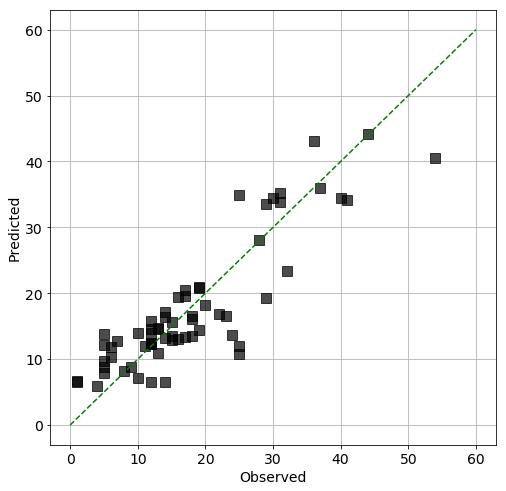

In [40]:
plt.figure(figsize=(8,8))
plt.plot(y_test.values,rf['prediction-test'],'ks',ms=10,alpha=0.7)
plt.plot([0,60],[0,60],'--g')
plt.grid()
plt.xlabel('Observed',fontsize=plotFontSize)
plt.ylabel('Predicted',fontsize=plotFontSize)
#plt.title('Regression using Random Forest Regressor')
plt.tick_params(labelsize = plotFontSize)
if savefig:
    plt.savefig('./fig_Regression/RandomForestCorrelation.png', dpi=600,bbox_inches='tight')
plt.show()

#### regression plot of XGB <span style="color:red" >[FIGURE FOR PAPER]</span>

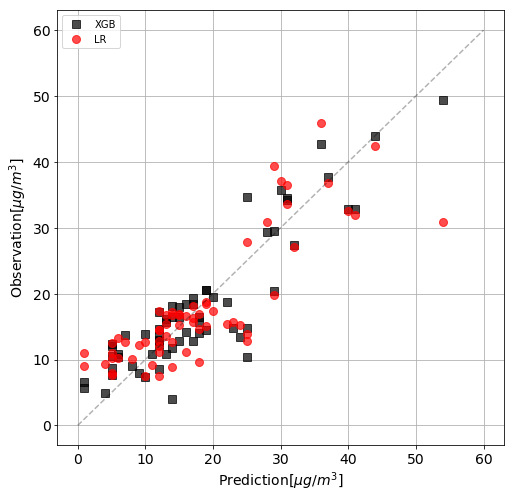

In [41]:
xgb = XGBRegressor()
xgb.fit(X_train,y_train)
lr = LinearRegression()
lr.fit(X_train,y_train)
plt.figure(figsize=(8,8))
plt.plot(y_test.values,xgb.predict(X_test),'ks',ms=8,alpha=0.7,label='XGB')
plt.plot(y_test.values,lr.predict(X_test),'ro',ms=8,alpha=0.7,label='LR')
plt.plot([0,60],[0,60],'--k',alpha=0.3)
plt.grid()
plt.xlabel('Prediction[$\mu g/m^3$]',fontsize=14)
plt.ylabel('Observation[$\mu g/m^3$]',fontsize=14)
plt.tick_params(labelsize = 14)
plt.legend()
savefig=True
if savefig:
    plt.savefig('./fig_Regression/XgbCorrelation.png', dpi=600,bbox_inches='tight')
plt.show()

## Residual plots 
Residual plots are a good way to visualize the errors in data. If you see structure in your data, that means your model is not capturing some thing, Maybe there is a interaction between 2 variables that you are not considering, or may be you are measuring time dependant data. If there are some structure in your data,your model should be checked again.  This random pattern indicates that a linear model provides a decent fit to the data. Before you look at the statistical measures for goodness-of-fit, you should check the residual plots. Residual plots can reveal unwanted residual patterns that indicate biased results more effectively than numbers. When your residual plots pass muster, you can trust your numerical results and check the goodness-of-fit statistics.



Residual Plot for random forest

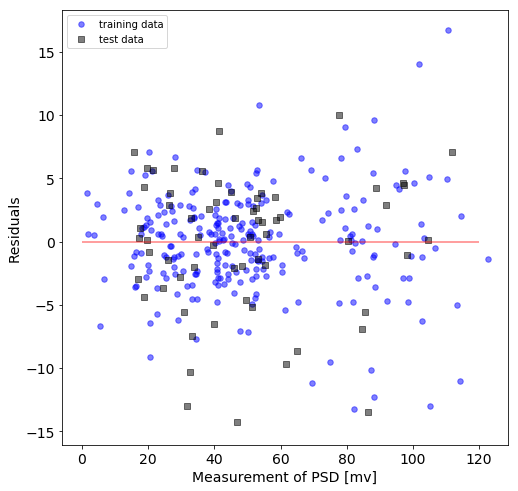

In [42]:
plt.figure(figsize=(8,8))
plt.scatter(X_train['mpd'], rf['Residual-train'], c='b', s=30, alpha=0.5)
plt.scatter(X_test['mpd'], rf['Residual-test'], marker='s',c='k', s=30, alpha = 0.5)
plt.hlines(y=0, xmin=0,xmax=120, alpha=0.5, colors='r')
plt.xlabel('Measurement of PSD [mv]',fontsize=14)
plt.ylabel('Residuals',fontsize=14)
#plt.title('Residual Plot')
plt.legend(['training data','test data'])
plt.tick_params(labelsize = 14)

if savefig:
    plt.savefig('./fig_Regression/RandomForestResidual.png', dpi=600,bbox_inches='tight')
plt.show()

A question regarding the number of data points for regression ? <br>
What is the minimum number of regression data points? hard to answer. Why don't we first find out how the number of data points affect regression result? <br>

For this analysis, test samples are not used. Ignore X_test, y_test.


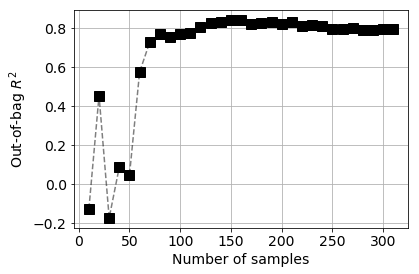

In [43]:
# rf_optimization_NoOfSamples function returns R2 of Random Forest Regressor
# based on no. of samples

def rf_optimization_NoOfSamples(X,y,noOfSamplesArray):
    
    outOfBagR2  = []
    minMaxArray = []
    rf = RandomForestRegressor(n_estimators=100, oob_score=True)
    for noOfSamples in noOfSamplesArray:
        XX = X[:noOfSamples]
        yy = y[:noOfSamples]
        rf.fit(XX, yy)
        outOfBagR2.append(rf.oob_score_)
        minMaxArray.append([XX['mpd'].min(), XX['mpd'].max()])
        
    # covert Python list into numpy array
    outOfBagR2 = np.array(outOfBagR2)
    minMaxArray = np.array(minMaxArray)
    
    # return outputs
    return {'oob-R2':outOfBagR2, 'minMax':minMaxArray}

# number of sample optimization
noOfSamplesArray =np.arange(10,X.shape[0],10)
rfOptNoOfSample = rf_optimization_NoOfSamples(X,y,noOfSamplesArray)  

# Plot
plotFontSize = 14
plt.plot(noOfSamplesArray, rfOptNoOfSample['oob-R2'],'ks',markersize=10)
plt.plot(noOfSamplesArray, rfOptNoOfSample['oob-R2'],'--k',alpha=0.5)
plt.ylabel('Out-of-bag $R^2$', fontsize = plotFontSize)
plt.xlabel('Number of samples', fontsize = plotFontSize)
plt.tick_params(labelsize = plotFontSize)

plt.grid()

if savefig:
    plt.savefig('./fig_Regression/NoOfSampleOptimization.png', dpi=600,bbox_inches='tight')
plt.show()

As the number of samples increases out-of-bag $R^2$ also increases and approaches a steady state value.
Above plot is <span style='color:red'>[FIGURE FOR PAPER]</span>

### Paper idea

- regression using machine learning algorithm <br>
  Algorithm to consider includes linear regressor as a baseline, random forester, artificial neural network.

- peer calibration using MQTT and K-nearest neighborhood method
  MQTT protocol : 
  topic : country/city/latitude/longitude/deviceID, 
  message : {'temp':23, 'humidity': 46, 'pm25' : 34}


### Hyperparameter Search
Try Random Forest first. It looks like there are not much difference in performance of Random Forest Regressor as the number of trees increases.

Import nessary sklearn libraries

In [44]:
# Grid Search Cross Validation
from sklearn.model_selection import GridSearchCV

#custom scoring function
from sklearn.metrics import make_scorer

User defined scoring function

In [45]:
# my custom scoring function (r2_score)
customScoring = make_scorer(score_func=r2_score, greater_is_better=True)

Create Random forest instance

In [46]:
# create Random Forest Instance
rfCV= RandomForestRegressor(oob_score=True, random_state=1)


Define Grid Search Parameters

In [47]:
# define the grid search parameters
param_grid = {'n_estimators' : [20,50,100,500]}
grid = GridSearchCV(estimator=rfCV, param_grid=param_grid, n_jobs=-1,cv=5, scoring=customScoring)
grid_result = grid.fit(X_train, y_train)

List Best score

In [48]:
print('*********** RESULTS **********************')
print('best: %f using %s' %(grid.best_score_, grid_result.best_params_))


*********** RESULTS **********************
best: 0.768523 using {'n_estimators': 500}


Mean and standard deviation of scores

In [49]:
print("Grid scores on development set:")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']

#THIS IS WHAT YOU WANT
for mean, std, params in zip(means, stds, grid_result.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Grid scores on development set:
0.762 (+/-0.163) for {'n_estimators': 20}
0.766 (+/-0.155) for {'n_estimators': 50}
0.765 (+/-0.150) for {'n_estimators': 100}
0.769 (+/-0.159) for {'n_estimators': 500}


#### Verification

In [50]:
verificationModel = RandomForestRegressor(oob_score=True, n_estimators=100)
verificationModel.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

#### Verification using test data set

0.7665144225250937


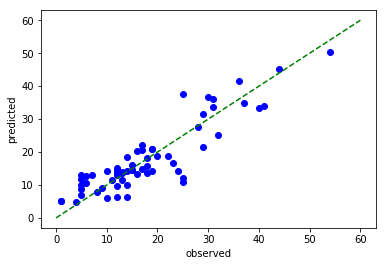

In [51]:
y_pred = verificationModel.predict(X_test)
print(r2_score(y_pred , y_test))

plt.plot(y_test,y_pred,'bo');plt.ylabel('predicted');plt.xlabel('observed');
plt.plot([0 ,60] ,[0, 60],'--g')
plt.show()

### Neural Network Regression

In [52]:
import keras
from keras.layers import Input,Dense,Activation,Dropout
from keras.models import Sequential,Model

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


#### Preparing MinMax Scaled Inputs to Neural network model

Create and compile a neural network model

In [53]:
X_in = X_train_mm_scaled.values # min-max scaled data
Y_in = y_train_mm_scaled.values

In [54]:
def create_model_NN(hiddenLayer1=64,hiddenLayer2=32,hiddenLayer3=8):
    model=Sequential()
    # input layer + hidden layer 1
    model.add(Dense(units=hiddenLayer1, activation='relu', kernel_initializer='uniform', input_dim=X_in.shape[1]))
    ## hidden layer 2
    model.add(Dense(units=hiddenLayer2,activation='relu'))
    model.add(Dropout(0.2))
    # hidden layer 3
    model.add(Dense(units=hiddenLayer3,activation='relu'))
    model.add(Dropout(0.2))
    # output layer
    model.add(Dense(units=1,activation='linear'))
    
    #model.add(Dense(32, input_dim=X_in.shape[1]))
    #model.add(Activation('relu'))
    #model.add(Dense(units=1,activation='linear'))
    # complile
    model.compile(optimizer='adam',loss='mean_squared_error')
    return model

NN_model = create_model_NN()

Fit a model to data

In [55]:
history = NN_model.fit(X_in,Y_in,epochs=500,batch_size=X_in.shape[0],verbose=0)


dict_keys(['loss'])


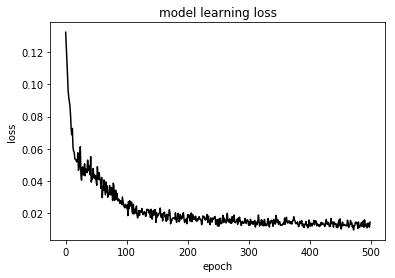

In [56]:
# plot of loss
print(history.history.keys())
plt.plot(history.history['loss'],'k')
plt.title('model learning loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Prediction

In [57]:
y_pred = NN_model.predict(X_test_mm_scaled.values)

$R^2$ score and RMS error for MinMax scaled data set

In [58]:
y_true = y_test_mm_scaled
y_true_original_scale = scalerMy.inverse_transform(y_true)

y_pred_original_scale = scalerMy.inverse_transform(y_pred)
r2_NN_model = r2_score(y_true_original_scale, y_pred_original_scale)

RMS_NN = np.sqrt(mean_squared_error(y_true_original_scale,y_pred_original_scale))

print('R2 of Neural Network Model        : %5.2f' %r2_NN_model)
print('RMS error of Neural Network Model : %5.2f' %RMS_NN)

R2 of Neural Network Model        :  0.73
RMS error of Neural Network Model :  5.74


In [59]:
[y_true.shape , y_pred.shape]

[(64, 1), (64, 1)]

Plot of Results from neural network regression model

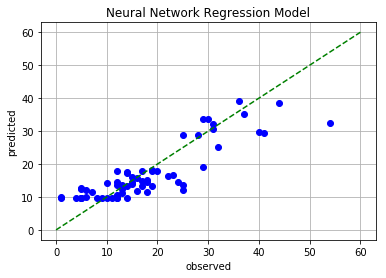

In [60]:
plt.plot(y_true_original_scale,y_pred_original_scale,'bo');
plt.plot([0,60],[0,60],'--g')
plt.xlabel('observed');plt.ylabel('predicted');plt.grid(True)
plt.title('Neural Network Regression Model')
plt.show()

### Neural Network Hyper-Parameter Tuning

For consistent result, you should set __`random_state`__ attribute.

**Performance of Linear regression and Neural Network** is compared with a scoring metric of **R2** (coefficient of determination).

<s>Before splitting data using K-fold, regression data should be checked to make sure training and test datasets are evenly distributed across min and max of data sets.</s>




#### KFold Cross Validation Test

In [61]:
# Neural network K-Fold Cross Validation
from sklearn.model_selection import StratifiedKFold

def KFoldNeuralNetwork(X_in,Y_in):
    kf = KFold(n_splits=5, shuffle=True, random_state=None)
    # plot data
    for i,(train_index, test_index) in enumerate(kf.split(X_in)):
        X_train, X_test = X_in[train_index], X_in[test_index]
        y_train, y_test = Y_in[train_index],  Y_in[test_index]
        NN_model = create_model_NN(hiddenLayer1=64)
        NN_model.fit(X_train,y_train,epochs=1000,batch_size=X_train.shape[0],verbose=0)
        y_pred = NN_model.predict(X_train)
        y_true = y_train
        r2_NN_model = r2_score(y_true, y_pred)
        print('r2 %3.2f' %r2_NN_model)
        
# Linear Regression K-Fold Cross Validation
def KFoldLinearRegression(X_in,Y_in):
    kf = KFold(n_splits=5, shuffle=True, random_state=None)
    print(kf)
    for i,(train_index, test_index) in enumerate(kf.split(X_in)):
        print(i)
        X_train, X_test = X_in[train_index], X_in[test_index]
        y_train, y_test = Y_in[train_index],  Y_in[test_index]
        lR_model = LinearRegression()
        lR_model.fit(X_train,y_train)
        y_pred = lR_model.predict(X_test)
        print( r2_score(y_test,y_pred))
        
def KFlodLinearRegressionAndNeuralNetworkComaprison(X_in,Y_in):
    # KFold = 5, shuffle before choosing
    kf = KFold(n_splits=5, shuffle=True, random_state=None)
    
    # R2 array
    r2_NN_model =[] # R2 array for neural network model
    r2_LR_model =[] # R2 array for Linear Regression model
    
    for i,(train_index, test_index) in enumerate(kf.split(X_in)):
        X_train, X_test = X_in[train_index], X_in[test_index]
        y_train, y_test = Y_in[train_index], Y_in[test_index]
        
        # Neural Network
        NN_model = create_model_NN(hiddenLayer1=32,hiddenLayer2=8)
        NN_model.fit(X_train,y_train,epochs=2000,batch_size=X_train.shape[0],verbose=0)
        y_pred = NN_model.predict(X_test)
        y_true = y_test
        r2_NN_model.append(r2_score(y_true, y_pred))
        
        # Linear Regression
        lR_model = LinearRegression()
        lR_model.fit(X_train,y_train)
        y_pred = lR_model.predict(X_test)
        r2_LR_model.append(r2_score(y_true, y_pred))
        
        # Display progress
        print('r2-NN: %3.2f, r2-LR:%3.2f' %(r2_NN_model[i],r2_LR_model[i]))
    
    # Display comparison results
    print('=================================================================')        
    print('Mean-r2-Neural Network: %3.2f, Mean-r2-Linear Regression:%3.2f' \
             %(np.mean(r2_NN_model), np.mean(r2_LR_model)))
    print('=================================================================')
    
    return {'r2-nn': np.mean(r2_NN_model), 'r2-lr': np.mean(r2_LR_model)}
    
# Repeat 10 times and workout mean
RepeatTrue = False
if(RepeatTrue):
    outList ={'r2-nn':[], 'r2-lr':[]}
    noOfRepetition = 1
    for i in range(noOfRepetition):
        out = KFlodLinearRegressionAndNeuralNetworkComaprison(X.values,y)
        outList['r2-nn'].append(out['r2-nn'])
        outList['r2-lr'].append(out['r2-lr'])
    print('************************************')    
    print('r2-nn:%5.2f, r2-lr:%5.2f'    %(np.mean(outList['r2-nn']), np.mean(outList['r2-lr'])))
    

#### GridSearch Hyper Parameter Tuning

In [62]:
# define the grid search parameters
# instantiation of Keras Sequential Model
from keras.wrappers.scikit_learn import KerasRegressor

# Custom scoring function
def myfunc(y_true,y_pred):
    # function execution counter
    myfunc.counter=vars(myfunc).setdefault('counter',0)
    myfunc.counter+=1
    # calculate R2
    r2 = r2_score(y_true,y_pred)
    
    print('r2 : %3.1f, count:%d' %(r2,myfunc.counter) )
    return r2

# Instantiate custom scoring function using `make_scorer` method
customR2 = make_scorer(score_func=myfunc)

# Keras Regression 
grid = KerasRegressor(build_fn=create_model_NN, verbose=0)

#grid parameter
param_gridNN = {'epochs' : [500,1000]}

# KFold
kf = KFold(n_splits=5, shuffle=True, random_state=43)

# grid search instance
#grid = GridSearchCV(estimator=grid, param_grid=param_gridNN, n_jobs=1,cv=kf ,scoring=customR2)

# Start grid search
#grid_result = grid.fit(X_in,Y_in)

In [63]:
# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#mean_test = grid_result.cv_results_['mean_test_score']
#mean_train = grid_result.cv_results_['mean_train_score']
#params = grid_result.cv_results_['params']
#for mean_train, mean_test, param in zip(mean_train, mean_test, params):
#    print("train:%f (test:%f) with: %r" % (mean_train, mean_test, param))